In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [ ]:
df = pd.read_csv('riceClassification.csv')

In [ ]:
df.dropna(inplace=True)
df.drop(['id'],axis=1,inplace=True)

In [ ]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
df['Class'].value_counts()

,count
Class,
1,9985
0,8200


In [ ]:
X = np.array(df.iloc[:, :-1])
y = np.array(df.iloc[:,-1])
X.shape , y.shape, y[:10]

((18185, 10), (18185,), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mnc = MinMaxScaler()
X_mnc = mnc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_mnc,y,test_size=0.3,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12729, 10), (5456, 10), (12729,), (5456,))

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=42)
X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2728, 10), (2728,), (2728, 10), (2728,))

In [ ]:
class dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X,dtype = torch.float32)
        self.y = torch.tensor(y,dtype = torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
train_data = dataset(X_train,y_train)
val_data = dataset(X_val,y_val)
test_data = dataset(X_test,y_test)

In [ ]:
train_dataloader = DataLoader(dataset=train_data,batch_size = 16,shuffle=True,num_workers=2)
val_dataloader = DataLoader(dataset=val_data,batch_size = 16,shuffle=False,num_workers=2)
test_dataloader = DataLoader(dataset=test_data,batch_size = 16,shuffle=False,num_workers=2)

In [ ]:
len(train_dataloader), len(test_dataloader)

(796, 171)

In [ ]:
hidden_units = 32
class ANNmodel(nn.Module):
    def __init__(self,drop=0.3):
        super(ANNmodel,self).__init__()

        self.input_layer = nn.Sequential(
            nn.Linear(X.shape[1],hidden_units),
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),
            nn.Dropout(drop),

            nn.Linear(hidden_units,hidden_units*2),
            nn.BatchNorm1d(2*hidden_units),
            nn.ReLU(),
            nn.Dropout(drop),

            nn.Linear(2*hidden_units,10),
            nn.BatchNorm1d(10),
            nn.ReLU(),
            nn.Dropout(drop),

            nn.Linear(10,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.input_layer(x)

In [ ]:
model = ANNmodel(drop=0.3).to(device)

In [ ]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = 0.001, weight_decay = 1e-5)

In [ ]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

epochs = 30

for epoch in range(epochs):

    train_loss , train_acc = 0.0 , 0.0
    val_loss, val_acc = 0.0 , 0.0

    for inputs,labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        model.train()
        y_pred = model(inputs)

        loss = loss_fn(y_pred.squeeze(),labels)
        train_loss += loss.item()

        train_acc += (y_pred.squeeze().round() == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader.dataset)
    train_acc  /= len(train_dataloader.dataset)

    model.eval()
    with torch.no_grad():
        for X,y in val_dataloader:
            X, y = X.to(device), y.to(device)
            y_pred_val = model(X)
            loss_val = loss_fn(y_pred_val.squeeze(),y)

            val_loss += loss_val.item()
            val_acc += (y_pred_val.squeeze().round() == y).sum().item()
    val_loss /= len(val_dataloader.dataset)
    val_acc  /= len(val_dataloader.dataset)

    total_loss_train_plot.append(train_loss)
    total_loss_validation_plot.append(val_loss)
    total_acc_train_plot.append(train_acc)
    total_acc_validation_plot.append(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")

Epoch [1/30] | Train Loss: 0.0119 | Train Acc: 95.84% | Val Loss: 0.0035 | Val Acc: 98.72%
Epoch [2/30] | Train Loss: 0.0063 | Train Acc: 97.05% | Val Loss: 0.0030 | Val Acc: 98.64%
Epoch [3/30] | Train Loss: 0.0055 | Train Acc: 97.31% | Val Loss: 0.0029 | Val Acc: 98.53%
Epoch [4/30] | Train Loss: 0.0047 | Train Acc: 97.70% | Val Loss: 0.0024 | Val Acc: 98.72%
Epoch [5/30] | Train Loss: 0.0045 | Train Acc: 97.69% | Val Loss: 0.0024 | Val Acc: 98.75%
Epoch [6/30] | Train Loss: 0.0041 | Train Acc: 98.02% | Val Loss: 0.0036 | Val Acc: 97.98%
Epoch [7/30] | Train Loss: 0.0044 | Train Acc: 97.81% | Val Loss: 0.0024 | Val Acc: 98.79%
Epoch [8/30] | Train Loss: 0.0048 | Train Acc: 97.86% | Val Loss: 0.0027 | Val Acc: 98.72%
Epoch [9/30] | Train Loss: 0.0038 | Train Acc: 98.35% | Val Loss: 0.0024 | Val Acc: 98.42%
Epoch [10/30] | Train Loss: 0.0039 | Train Acc: 98.11% | Val Loss: 0.0037 | Val Acc: 98.02%
Epoch [11/30] | Train Loss: 0.0041 | Train Acc: 98.22% | Val Loss: 0.0026 | Val Acc: 98.5

In [ ]:
all_predictions = []
all_labels = []

model.eval()
print(f"Model is in eval mode: {not model.training}")


with torch.inference_mode():
    for batch_idx, (X_batch, y_batch) in enumerate(test_dataloader):

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(X_batch).squeeze()

        predictions = y_pred.round()

        all_predictions.extend(predictions.cpu().numpy().astype(int))
        all_labels.extend(y_batch.cpu().numpy().astype(int))

correct = sum([1 for true, pred in zip(all_labels, all_predictions) if true == pred])
accuracy = correct / len(all_labels) * 100
print(f"\nAccuracy : {accuracy:.2f}%")

Model is in eval mode: True

Accuracy : 99.45%


Label Distribution:
True labels - Class 0: 1240, Class 1: 1488
Predictions - Class 0: 1237, Class 1: 1491

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.99      0.99      1240
     Class 1       0.99      1.00      0.99      1488

    accuracy                           0.99      2728
   macro avg       0.99      0.99      0.99      2728
weighted avg       0.99      0.99      0.99      2728


Confusion Matrix:
[[1231    9]
 [   6 1482]]


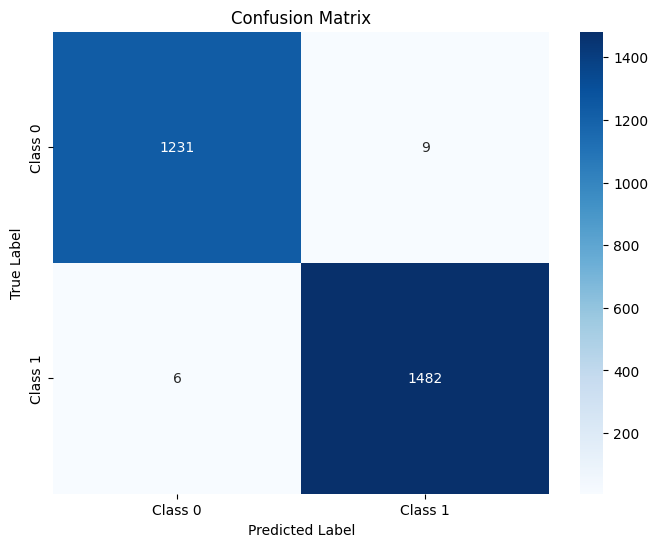

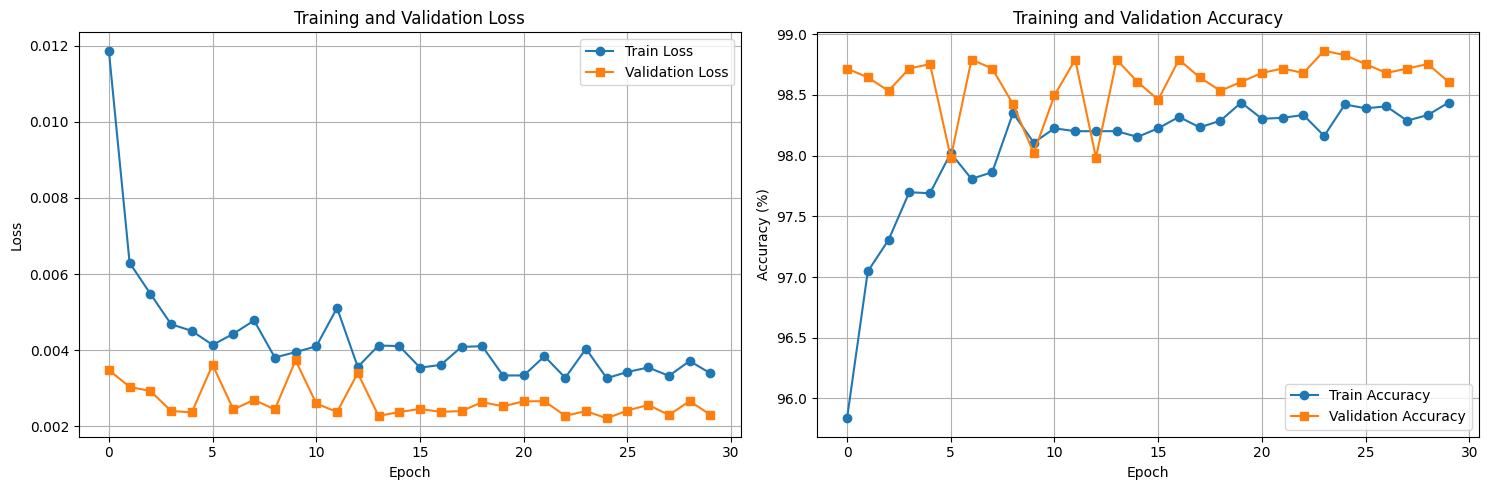

In [ ]:
print("Label Distribution:")
print(f"True labels - Class 0: {all_labels.count(0)}, Class 1: {all_labels.count(1)}")
print(f"Predictions - Class 0: {all_predictions.count(0)}, Class 1: {all_predictions.count(1)}")



from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions,
                          target_names=['Class 0', 'Class 1']))


cm = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(cm)

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(total_loss_train_plot, label='Train Loss', marker='o')
ax1.plot(total_loss_validation_plot, label='Validation Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot([acc*100 for acc in total_acc_train_plot], label='Train Accuracy', marker='o')
ax2.plot([acc*100 for acc in total_acc_validation_plot], label='Validation Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# CONTINUATION FROM YOUR EXISTING CODE

print("\n" + "="*50)
print("MANUAL PREDICTION INPUT")
print("="*50)

# Take user input for each feature
print("Please enter the following features for prediction:")

# Get raw inputs
area = float(input("Area: "))
MajorAxisLength = float(input("Major Axis Length: "))
MinorAxisLength = float(input("Minor Axis Length: "))
Eccentricity = float(input("Eccentricity: "))
ConvexArea = float(input("Convex Area: "))
EquivDiameter = float(input("EquivDiameter: "))
Extent = float(input("Extent: "))
Perimeter = float(input("Perimeter: "))
Roundness = float(input("Roundness: "))
AspectRation = float(input("AspectRation: "))

my_inputs = [area, MajorAxisLength, MinorAxisLength, Eccentricity, ConvexArea,
             EquivDiameter, Extent, Perimeter, Roundness, AspectRation]

print("="*20)


# Use the SAME MinMaxScaler that was used during training
my_inputs_array = np.array(my_inputs).reshape(1, -1)
my_inputs_normalized = mnc.transform(my_inputs_array)  # Use the trained scaler


# Convert to tensor and reshape to 2D (add batch dimension)
model_inputs = torch.Tensor(my_inputs_normalized).to(device)  # Shape: [1, 10]


# Make prediction
model.eval()
with torch.no_grad():
    prediction = model(model_inputs)

prediction_prob = prediction.item()
print(f"Prediction probability: {prediction_prob:.4f}")
print("Class is: ", round(prediction_prob))

# Additional interpretation
if round(prediction_prob) == 1:
    print("Jasmine")
else:
    print("Gonen")

print("="*50)


MANUAL PREDICTION INPUT
Please enter the following features for prediction:
Area: 5619
Major Axis Length: 142.705
Minor Axis Length: 51.14329
Eccentricity: 0.9333574
Convex Area: 5738
EquivDiameter: 84.58329
Extent: 0.509152
Perimeter: 320.902
Roundness: 0.685684
AspectRation: 2.790269
Prediction probability: 0.9976
Class is:  1
Jasmine
